In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from pmdarima.arima import auto_arima

In [3]:
df = pd.read_csv("C:/Users/syaki/Documents/~COURSE WORK/LINKEDIN + JS.csv")
df.head()

,Job Titles,Employees,Industry,City,State,Country,Date Post,Job Skills
0,Account Specialist -TP,"10,001+ employees",IT Services and IT Consulting,Petaling Jaya,Selangor,Malaysia,12/9/2023,"Analytical Skills and Communication,Accounts P..."
1,Account&Admin Assistant,51-200 employees,"Technology, Information and Internet",Shah Alam,Selangor,Malaysia,1/12/2024,"Accounting Software, Databases, and Problem So..."
2,"Accounting, Compliance & Reporting, Associate","10,001+ employees",IT Services and IT Consulting,Kuala Lumpur,Federal Territory of Kuala Lumpur,Malaysia,1/11/2024,"Accounting Standards, Compliance Management, D..."
3,Ad Operation Executive,201-500 employees,"Advertising, Sales, Arts & Media",Petaling Jaya,Selangor,Malaysia,12/6/2023,"Analytical Skills and Data Analysis,A/B Testin..."
4,Admin Assistant,51-200 employees,"Banking, Accounting & Financial Services",Petaling Jaya,Selangor,Malaysia,1/4/2024,"Communication,Communication Training, English,..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Job Titles  1317 non-null   object
 1   Employees   1317 non-null   object
 2   Industry    1317 non-null   object
 3   City        1317 non-null   object
 4   State       1317 non-null   object
 5   Country     1317 non-null   object
 6   Date Post   1317 non-null   object
 7   Job Skills  1317 non-null   object
dtypes: object(8)
memory usage: 82.4+ KB


In [5]:
df.columns

Index(['Job Titles', 'Employees', 'Industry', 'City', 'State', 'Country',
       'Date Post', 'Job Skills'],
      dtype='object')

In [6]:
df.drop(columns=['Employees', 'Industry', 'City', 'State', 'Country', 'Job Skills'], inplace=True)

In [7]:
df.describe()

,Job Titles,Date Post
count,1317,1317
unique,1079,67
top,Data Analyst,1/27/2024
freq,20,103


In [8]:
# Preprocess the time series data
df['Date Post'] = pd.to_datetime(df['Date Post'])
df['Job Titles'] = LabelEncoder().fit_transform(df['Job Titles'])  # Label encoding for Job Titles
df_grouped = df.groupby('Date Post')['Job Titles'].sum().reset_index()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1317 entries, 0 to 1316
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Job Titles  1317 non-null   int32         
 1   Date Post   1317 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(1)
memory usage: 15.6 KB


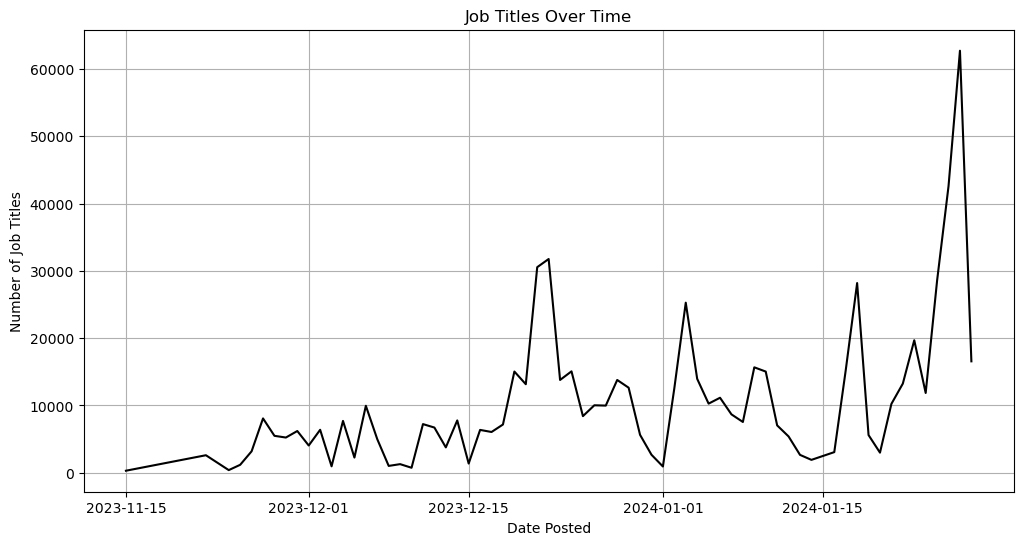

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Job Titles', color='black')
plt.title('Job Titles Over Time')
plt.xlabel('Date Posted')
plt.ylabel('Number of Job Titles')
plt.grid(True)
plt.show()

In [11]:
# Split the data into Training and Testing
# Used slicing with iloc. By directly selecting rows using integer-based indexing
print(df.shape)
train=df.iloc[:-30]
test=df.iloc[-30:]
print(train.shape, test.shape)

(1317, 2)
(1287, 2) (30, 2)


In [12]:
# Method 3: ADF Test
adf_test = adfuller(train['Job Titles'])
print(f'p-values: {adf_test[1]}')
# Since P-value is more than p <- 0.05. we fail to reject the null hypothesis.
# H0 = non-stationary

p-values: 0.07632429585751271


<Axes: >

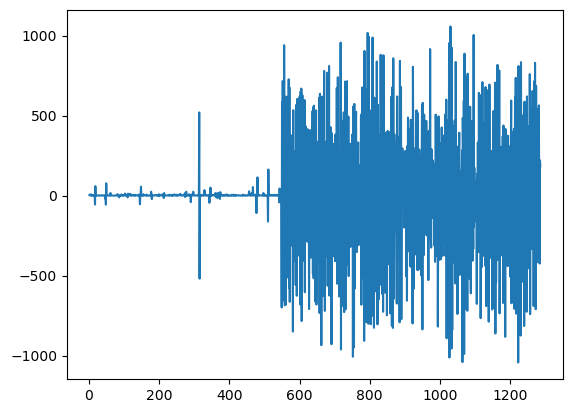

In [13]:
# Transform to stationary : Differencing d=1
train_diff = train['Job Titles'].diff().dropna()
train_diff.plot()

In [14]:
adf_test = adfuller(train_diff)
print(f'p-values: {adf_test[1]}')
# Set the ARIMA (p, 1, q)
# First difference time series is stationary

p-values: 1.9297460700403748e-22


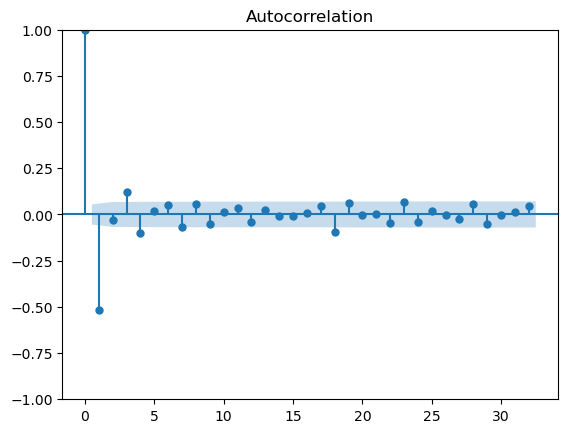

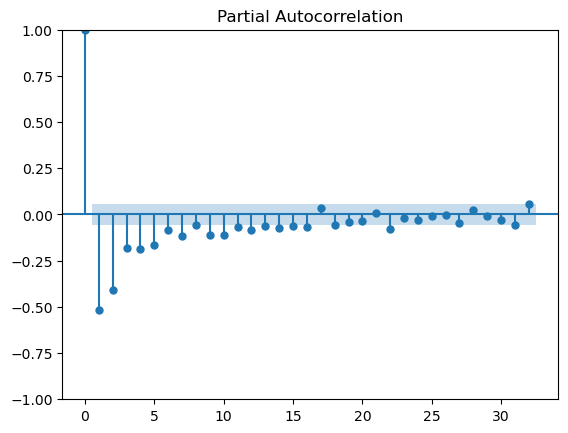

In [15]:
# Plot ACF
acf_diff = plot_acf(train_diff)

# Plot PACF
pacf_diff = plot_pacf(train_diff)

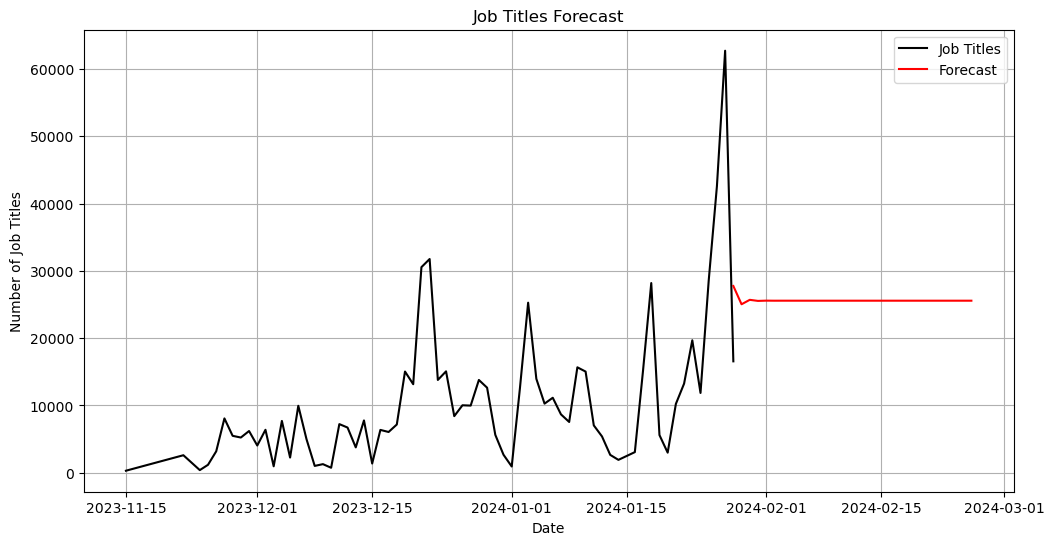

In [16]:
# Fit ARIMA model
model = ARIMA(df_grouped['Job Titles'], order=(1, 1, 0))
model_fit = model.fit()

# Step 4: Generate forecasts
forecast_steps = 30  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Step 5: Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Job Titles', color='black')
plt.plot(pd.date_range(start=df_grouped['Date Post'].max(), periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.title('Job Titles Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Job Titles')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
# Auto Arima Forecasting
model = pm.auto_arima(df_grouped['Job Titles'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1394.709, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1398.657, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1398.024, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1393.496, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1396.710, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1387.821, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1394.109, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1387.671, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1389.398, Time=0.06 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 1.075 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 1, 3)   Log Likelihood             

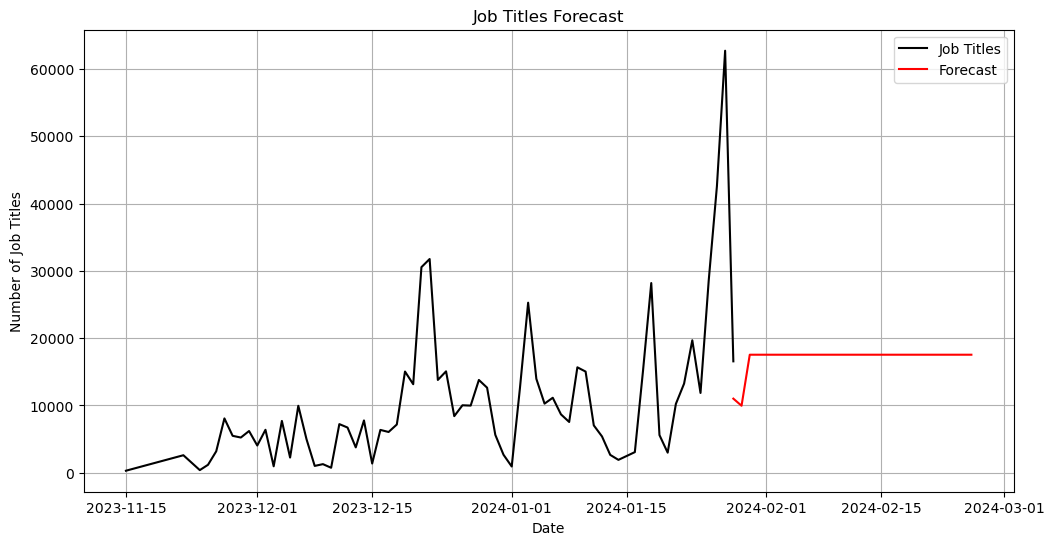

In [18]:
# Fit ARIMA model
model = ARIMA(df_grouped['Job Titles'], order=(0, 1, 3))
model_fit = model.fit()

# Step 4: Generate forecasts
forecast_steps = 30  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Step 5: Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Job Titles', color='black')
plt.plot(pd.date_range(start=df_grouped['Date Post'].max(), periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.title('Job Titles Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Job Titles')
plt.grid(True)
plt.legend()
plt.show()

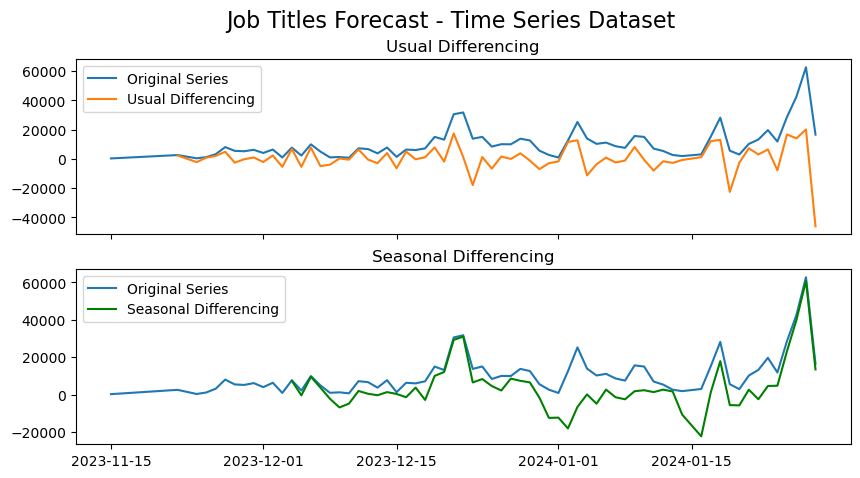

In [19]:
# Seasonal ARIMA model (in short SARIMA) which uses seasonal differencing.
# SARIMA(p,d,q)x(P,D,Q) 
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Original Series')
axes[0].plot(df_grouped['Date Post'], df_grouped['Job Titles'].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal Differencing
axes[1].plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Original Series')
axes[1].plot(df_grouped['Date Post'], df_grouped['Job Titles'].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle('Job Titles Forecast - Time Series Dataset', fontsize=16)
plt.show()
# Show seasonal spikes are intact after applying usual differencing (lag 1)

In [20]:
# Step 1: Seasonal - fit stepwise auto-ARIMA. Set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.
smodel = pm.auto_arima(df_grouped['Job Titles'], start_p=0, start_q=0,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1164.988, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1166.387, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1166.070, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=1174.138, Time=0.13 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1166.002, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=1164.673, Time=0.03 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1164.891, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=1161.152, Time=0.13 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=1160.691, Time=0.34 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1158.697, Time=0.22 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1160.561, Time=0.16 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1155.803, Time=0.54 sec
 ARIMA(1,1,1)(1,1,0)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   67
Model:             SARIMAX(2, 1, 1)x(2, 1, [], 12)   Log Likelihood                -571.622
Date:                             Wed, 20 Mar 2024   AIC                           1155.243
Time:                                     14:17:06   BIC                           1167.177
Sample:                                          0   HQIC                          1159.846
                                              - 67                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.250      2.640      0.008       0.170       1.148
ar.L2         -0.3158      0.350     -0.903      0.366      -1.001       0.369
ma.L1         -0.9512      0.179     -5.306      0.000      -1.303      -0.600
ar.S.L12      -0.6521      0.375     -1.737      0.082      -1.388       0.084
ar.S.L24      -0.4902      0.253     -1.938      0.053      -0.986       0.006
sigma2      1.233e+08   2.01e-09   6.13e+16      0.000    1.23e+08    1.23e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 8.08
Prob(Q):                              0.89   Prob(JB):                         0.02
Heteroskedasticity (H):               3.64   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+33. Standard errors may be unstable.
"""

C:\Users\syaki\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


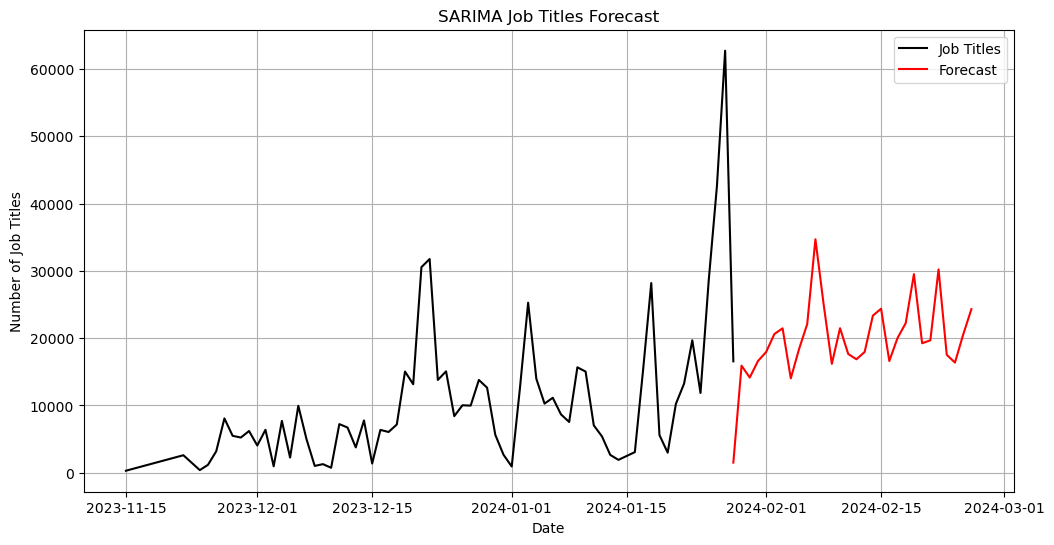

In [21]:
# Fit SARIMA model
model = SARIMAX(df_grouped['Job Titles'], order=(2, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit = model.fit()

# Step 2: Generate forecasts
forecast_steps = 30  # Number of steps to forecast
forecast = model_fit.forecast(steps=forecast_steps)

# Step 3: Plot the original data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Job Titles', color='black')
plt.plot(pd.date_range(start=df_grouped['Date Post'].max(), periods=forecast_steps, freq='D'), forecast, label='Forecast', color='red')
plt.title('SARIMA Job Titles Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Job Titles')
plt.grid(True)
plt.legend()
plt.show()

C:\Users\syaki\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


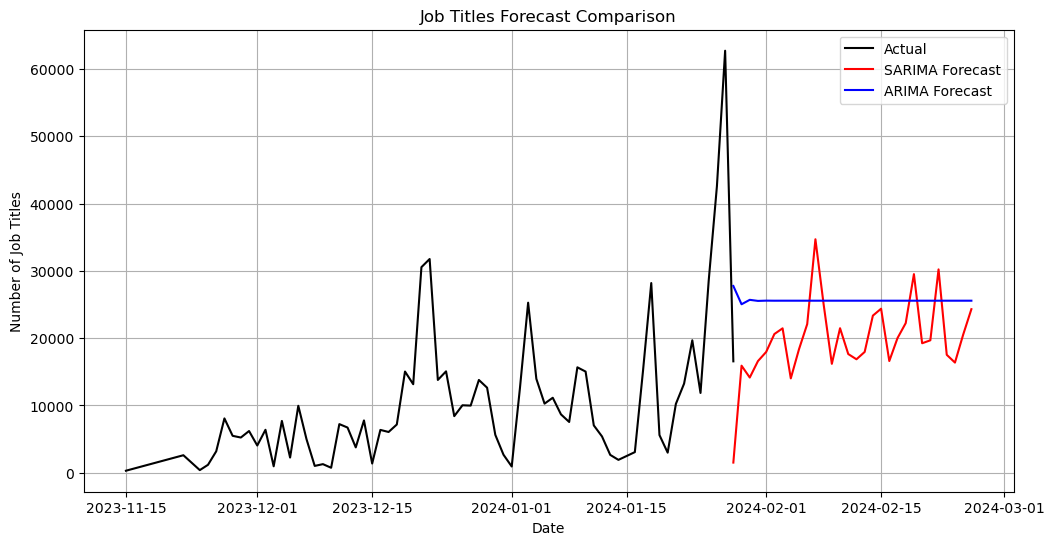

In [22]:
# Fit SARIMA model
model_sarima = SARIMAX(df_grouped['Job Titles'], order=(2, 1, 1), seasonal_order=(2, 1, 0, 12))
model_fit_sarima = model_sarima.fit()

# Generate SARIMA forecasts
forecast_steps = 30  # Number of steps to forecast
forecast_sarima = model_fit_sarima.forecast(steps=forecast_steps)

# Fit ARIMA model
model_arima = ARIMA(df_grouped['Job Titles'], order=(1, 1, 0))
model_fit_arima = model_arima.fit()

# Generate ARIMA forecasts
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# Plot both forecasts in one graph
plt.figure(figsize=(12, 6))
plt.plot(df_grouped['Date Post'], df_grouped['Job Titles'], label='Actual', color='black')
plt.plot(pd.date_range(start=df_grouped['Date Post'].max(), periods=forecast_steps, freq='D'), forecast_sarima, label='SARIMA Forecast', color='red')
plt.plot(pd.date_range(start=df_grouped['Date Post'].max(), periods=forecast_steps, freq='D'), forecast_arima, label='ARIMA Forecast', color='blue')
plt.title('Job Titles Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Number of Job Titles')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
# Calculate MSE and MAE for ARIMA forecast
mse_arima = mean_squared_error(df_grouped['Job Titles'][-forecast_steps:], forecast_arima)
mae_arima = mean_absolute_error(df_grouped['Job Titles'][-forecast_steps:], forecast_arima)

print("ARIMA Model:")
print("ARIMA Forecast MSE:", mse_arima)
print("ARIMA Forecast MAE:", mae_arima)

ARIMA Model:
ARIMA Forecast MSE: 301471505.7047637
ARIMA Forecast MAE: 15633.126703244476


In [24]:
# Calculate MSE and MAE for SARIMA forecast
mse_sarima = mean_squared_error(df_grouped['Job Titles'][-forecast_steps:], forecast_sarima)
mae_sarima = mean_absolute_error(df_grouped['Job Titles'][-forecast_steps:], forecast_sarima)

print("SARIMA Model:")
print("SARIMA Forecast MSE:", mse_sarima)
print("SARIMA Forecast MAE:", mae_sarima)

SARIMA Model:
SARIMA Forecast MSE: 240340161.7681543
SARIMA Forecast MAE: 13024.877919052307
